# Import Libraries

In [ ]:
%pip install pytorch-lightning

In [ ]:
%pip install natsort

In [ ]:
%pip install scikit-image

In [ ]:
%pip install --upgrade torchvision

In [ ]:
%pip install marshmallow_dataclass

In [ ]:
%pip install marshmallow_enum

In [ ]:
%pip install wandb

In [ ]:
%pip install imantics

In [ ]:
%pip install omegaconf

In [ ]:
%pip install hydra-core

In [ ]:
%pip install pycocotools

In [1]:
!git clone https://github.com/frgfm/torch-cam

Cloning into 'torch-cam'...
remote: Enumerating objects: 5881, done.
remote: Counting objects: 100% (1420/1420), done.
remote: Compressing objects: 100% (504/504), done.
remote: Total 5881 (delta 979), reused 1307 (delta 907), pack-reused 4461
Receiving objects: 100% (5881/5881), 9.32 MiB | 4.77 MiB/s, done.
Resolving deltas: 100% (4039/4039), done.


In [3]:
import pytorch_lightning as pl

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import glob
import pathlib
import skimage
from skimage import io
import shutil
#import cv2
from natsort import natsorted
import pathlib
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional as F
import torchvision



from torchvision import transforms
from torch import long, tensor
from torch import optim, nn, utils, Tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor
from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.autograd import Variable
from torchmetrics import Accuracy
from torchmetrics.functional import accuracy
from torchvision.models.feature_extraction import create_feature_extractor

from zia_vision.base_model import ImageClassificationModelLight

In [30]:
os.rename('torch-cam','torch_cam_folder')
os.mkdir('./torch_cam_folder/torchcam/torchcam')

In [31]:
files = os.listdir('./torch_cam_folder/torchcam')
for file in files:
    if file != '__init__.py' && file != 'torchcam':
        origin = './torch_cam_folder/torchcam/' + file
        dest = './torch_cam_folder/torchcam/torchcam/' + file
        shutil.move(origin,dest )

Error: Cannot move a directory './torch_cam_folder/torchcam/torchcam' into itself './torch_cam_folder/torchcam/torchcam/torchcam'.

In [32]:
file

'torchcam'

In [12]:
from torch_cam_folder.torchcam.methods.gradient import LayerCAM

In [2]:
p = pathlib.Path("./val")
p.mkdir(parents=True, exist_ok=True)
p = pathlib.Path("./test")
p.mkdir(parents=True, exist_ok=True)

In [2]:
TRAIN_DATASETS_PATH = './train'
TEST_DATASETS_PATH = './test'
VAL_DATASETS_PATH = './val'

In [4]:
#Create Test dataset with 1/4 of the images in each train folder 

folders = Path(TRAIN_DATASETS_PATH)
folders_list = list(folders.iterdir())
folders_list_os = os.listdir(TRAIN_DATASETS_PATH)

for x in range(len(folders_list)):
    folder_path = "./test" + '/' + folders_list_os[x]
    p = pathlib.Path(folder_path)
    p.mkdir(parents=True, exist_ok=True)

    images_path = TRAIN_DATASETS_PATH + '/' + folders_list_os[x]
    dest = TEST_DATASETS_PATH + '/' + folders_list_os[x]
    
    if folders_list_os[x] == '.DS_Store':          
        os.remove(folders_list_os[x])
        
    files = os.listdir(images_path)

    for index_files in range(round(len(files)/4)):
        imgPath = images_path + '/' + files[index_files]
        dest_2 = dest + '/' + files[index_files]
        shutil.move(imgPath,dest_2 )

In [5]:
#Create Validation dataset with 1/4 of the images in each train folder 

folders = Path(TRAIN_DATASETS_PATH)
folders_list = list(folders.iterdir())
folders_list_os = os.listdir(TRAIN_DATASETS_PATH)

for x in range(len(folders_list)):
    folder_path = "./val" + '/' + folders_list_os[x]
    p = pathlib.Path(folder_path)
    p.mkdir(parents=True, exist_ok=True)

    images_path = TRAIN_DATASETS_PATH + '/' + folders_list_os[x]
    dest = VAL_DATASETS_PATH + '/' + folders_list_os[x]
    
    if folders_list_os[x] == '.DS_Store':          
        os.remove(folders_list_os[x])
        
    files = os.listdir(images_path)

    for index_files in range(round(len(files)/4)):
        imgPath = images_path + '/' + files[index_files]
        dest_2 = dest + '/' + files[index_files]
        shutil.move(imgPath,dest_2 )

# Load Checkpoints

In [3]:
ckpt_path = "./best_model_acc_image_classification.ckpt"
#ckpt_path ="./example_model.ckpt"

In [4]:
model = ImageClassificationModelLight.load_from_checkpoint(ckpt_path)

# LIME

In [ ]:
%pip install lime

In [5]:
from lime import lime_tabular, lime_image

In [6]:
explainer = lime_image.LimeImageExplainer()

In [7]:
folders = os.listdir(TRAIN_DATASETS_PATH)
folders = natsorted(folders)

image_DF = pd.DataFrame([])

for index_folder in range(1): # len(folders)-20):
    images_path = TRAIN_DATASETS_PATH + '/' + folders[index_folder]
    files = os.listdir(images_path)

    for index_files in range(len(files)):
        imgPath = images_path + '/' + files[index_files]

        image = Image.open(imgPath)
        new_image = image.resize((256, 256))

        image = np.array(new_image)
        #image = cv2.imread(imgPath)

        image_DF = image_DF.append({'image': image,'image_name':files[index_files]}, ignore_index=True)


/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel_71220/1486894543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_DF = image_DF.append({'image': image,'image_name':files[index_files]}, ignore_index=True)
/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel_71220/1486894543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_DF = image_DF.append({'image': image,'image_name':files[index_files]}, ignore_index=True)
/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel_71220/1486894543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_DF = image_DF.append({'image': image,'image_name':files[index_files]}, ignore_index=True)
/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel

/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel_71220/1486894543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_DF = image_DF.append({'image': image,'image_name':files[index_files]}, ignore_index=True)
/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel_71220/1486894543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_DF = image_DF.append({'image': image,'image_name':files[index_files]}, ignore_index=True)
/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel_71220/1486894543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_DF = image_DF.append({'image': image,'image_name':files[index_files]}, ignore_index=True)
/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel

/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel_71220/1486894543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_DF = image_DF.append({'image': image,'image_name':files[index_files]}, ignore_index=True)
/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel_71220/1486894543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_DF = image_DF.append({'image': image,'image_name':files[index_files]}, ignore_index=True)
/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel_71220/1486894543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_DF = image_DF.append({'image': image,'image_name':files[index_files]}, ignore_index=True)
/var/folders/cj/w8zhc6994wl95228lsyclc2c0000gn/T/ipykernel

In [8]:
IMAGES_train = image_DF['image']

In [9]:
IMAGES_train = np.array(IMAGES_train)

In [10]:
IMAGES_tensor = torch.tensor(IMAGES_train[0].reshape(1,3,256,256), dtype = torch.float)

In [11]:
explanation = explainer.explain_instance(IMAGES_train[0].astype('double'), model.compute_embeddings_tens, top_labels=512, hide_color=0, num_samples=1000)

100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.67it/s]


In [24]:
model.model.forward_features(IMAGES_tensor).shape

torch.Size([1, 512, 8, 8])

In [23]:
??model.model

In [20]:
import timm

In [21]:
??timm.create_model

In [25]:
from skimage.segmentation import mark_boundaries

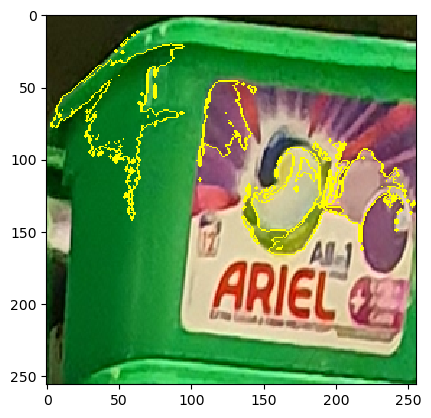

In [26]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

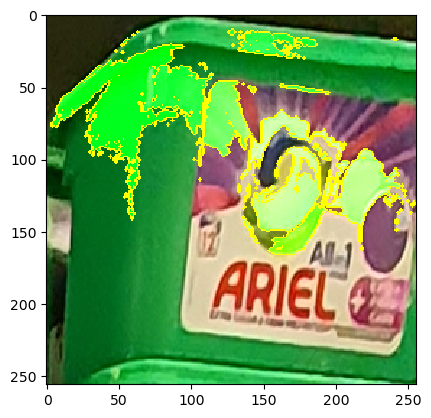

In [27]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

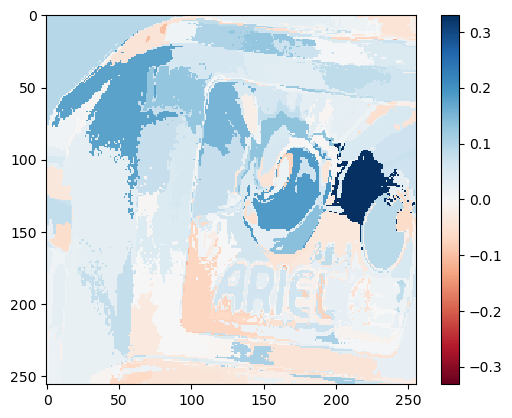

In [28]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Grad Cam

In [39]:
%pip install grad-cam

Note: you may need to restart the kernel to use updated packages.


In [40]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget, ClassifierOutputTarget
import PIL

In [41]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [42]:
target_layers = model.model.layer4
target_layers

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_block): Identity()
    (act1): ReLU(inplace=True)
    (aa): Identity()
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_block): Identity()
    (act1): ReLU(inplace=True)
    (aa): Identi

In [43]:
cam = GradCAM(model=model.model, target_layers=target_layers, use_cuda=False)

In [44]:
folders = os.listdir(TRAIN_DATASETS_PATH)
folders = natsorted(folders)

for index_folder in range(2):
    images_path = TRAIN_DATASETS_PATH + '/' + folders[index_folder]
    files = os.listdir(images_path)

    for index_files in range(len(files)):
        imgPath = images_path + '/' + files[index_files]

In [45]:
image = Image.open(imgPath)

# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [46]:
image = PIL.Image.open(imgPath)
crop = image
convert_tensor = transforms.ToTensor()
crop = convert_tensor(crop)
crop = crop.unsqueeze(0)

In [47]:
targets = [ClassifierOutputTarget(180)]

In [48]:
grayscale_cam = cam(input_tensor=crop , targets=targets)

In [49]:
visualization = show_cam_on_image(np.transpose(crop[0,:].numpy(), (1,2,0)), grayscale_cam[0,:], use_rgb=True)

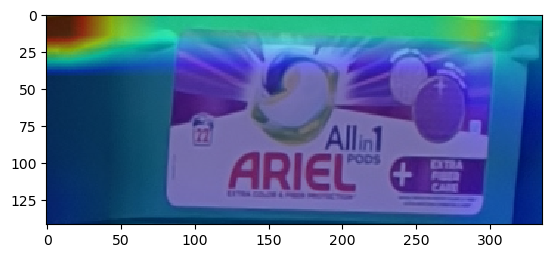

In [50]:
plt.imshow(visualization)

# Smooth Grad Cam++

In [8]:
!git clone https://github.com/yiskw713/SmoothGradCAMplusplus

Cloning into 'SmoothGradCAMplusplus'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 47 (delta 13), reused 24 (delta 11), pack-reused 20
Receiving objects: 100% (47/47), 3.29 MiB | 1.95 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [10]:
cam_path = "./SmoothGradCAMplusplus/cam.py"
utils_path = "./SmoothGradCAMplusplus/utils"
destination_cam_utils_path = "./"

shutil.move(cam_path,destination_cam_utils_path)
shutil.move(utils_path,destination_cam_utils_path)

'./utils'

In [52]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from cam_sigmo import SmoothGradCAMpp_2
from utils.visualize import visualize, reverse_normalize

In [6]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [7]:
folders = os.listdir(TRAIN_DATASETS_PATH)
folders = natsorted(folders)

for index_folder in range(2):
    images_path = TRAIN_DATASETS_PATH + '/' + folders[index_folder]
    if images_path[-9:] == '.DS_Store':          
        os.remove(images_path)
    else:
        files = os.listdir(images_path)

    for index_files in range(len(files)):
        imgPath = images_path + '/' + files[index_files]

In [8]:
image = Image.open(imgPath)

# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [9]:
model.eval()

ImageClassificationModelLight(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [10]:
from functools import reduce

def get_module_by_name(module, access_string):
    names = access_string.split(sep='.')
    return reduce(getattr, names, module)


In [11]:
from timm.models.layers import SelectAdaptivePool2d

In [12]:
new_model = model.model
new_model.fc = nn.Identity()
new_model.global_pool = SelectAdaptivePool2d(pool_type='avg', flatten=None)
new_model.fc = torch.nn.Flatten()

In [13]:
target_layers = new_model.layer4[-1]
target_layers

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_block): Identity()
  (act1): ReLU(inplace=True)
  (aa): Identity()
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
)

In [14]:
# target_layers = model.model.layer4[-1]
# wrapped_model = SmoothGradCAMpp(model.model, target_layers)
# target_layers

In [15]:
wrapped_model_new = SmoothGradCAMpp(new_model, target_layers)
wrapped_model_sigmo = SmoothGradCAMpp_2(new_model, target_layers)
# wrapped_model_2 = SmoothGradCAMpp(new_model, target_layers_2)

In [16]:
cam, idx = wrapped_model_new(tensor)

/Users/federicocalderon/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 96	 probability 0.017137959599494934


In [17]:
cam_sigmo, idx_sigmo = wrapped_model_sigmo(tensor)

Feature element ids 96	 probability 0.6548072786442936


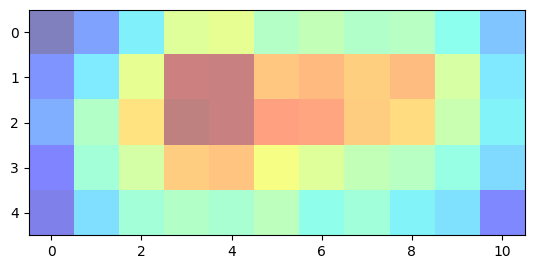

In [18]:
# visualize only cam
plt.imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

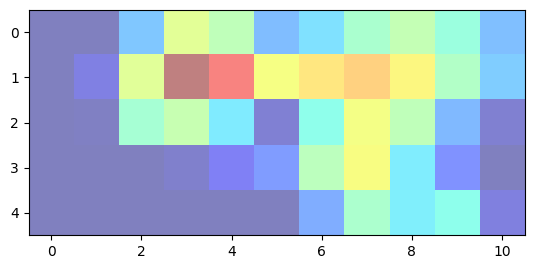

In [19]:
plt.imshow(cam_sigmo.squeeze().numpy(), alpha=0.5, cmap='jet')

In [20]:
img = reverse_normalize(tensor)

In [21]:
heatmap = visualize(img, cam)
heatmap_sigmo = visualize(img, cam_sigmo)

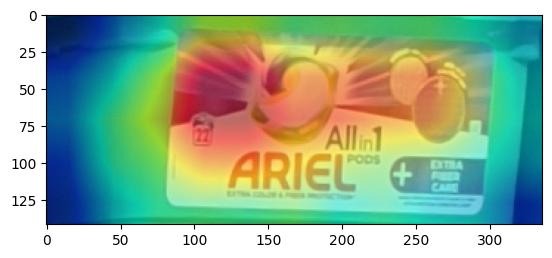

In [22]:
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
plt.imshow(hm)

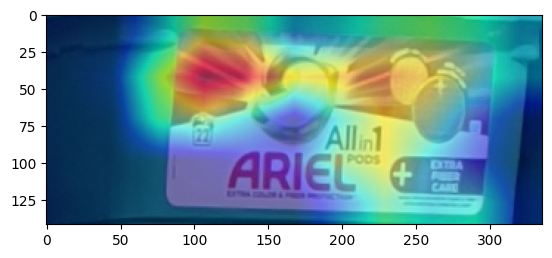

In [23]:
hm_sigmo = (heatmap_sigmo.squeeze().numpy().transpose(1, 2, 0))
plt.imshow(hm_sigmo)

# Extract localization cues

Cloning into 'torch-cam'...
remote: Enumerating objects: 5881, done.
remote: Counting objects: 100% (1419/1419), done.
remote: Compressing objects: 100% (503/503), done.
remote: Total 5881 (delta 978), reused 1307 (delta 907), pack-reused 4462
Receiving objects: 100% (5881/5881), 9.32 MiB | 2.96 MiB/s, done.
Resolving deltas: 100% (4040/4040), done.


# Deep Feature Factorisation

In [ ]:
%pip install grad-cam

In [ ]:
from pytorch_grad_cam import DeepFeatureFactorization
from pytorch_grad_cam.utils.image import show_factorization_on_image

In [ ]:
dff = DeepFeatureFactorization(model=model.model, target_layer=target_layers, computation_on_concepts=model.model.fc)

In [ ]:
input_tensor = tensor
n_components = 4
concepts, batch_explanations, concept_scores = dff(input_tensor, n_components)

In [ ]:
rgb_img_float = skimage.img_as_float(image)

In [ ]:
visualization = show_factorization_on_image(rgb_img_float, 
                                            batch_explanations[0],
                                            image_weight=0.3)

In [ ]:
result = np.hstack((rgb_img_float, visualization))

In [ ]:
def visualize_image(model, img, tensor, n_components=4, top_k=2):
    rgb_img_float = skimage.img_as_float(img)
    input_tensor = tensor
    classifier = model.fc
    dff = DeepFeatureFactorization(model=model, target_layer=model.layer4, 
                                   computation_on_concepts=classifier)
    concepts, batch_explanations, concept_outputs = dff(input_tensor, n_components)
    
    concept_outputs = torch.softmax(torch.from_numpy(concept_outputs), axis=-1).numpy()    
    visualization = show_factorization_on_image(rgb_img_float, 
                                                batch_explanations[0],
                                                image_weight=0.3)
    
    result = np.hstack((img, visualization))
    
    # Just for the jupyter notebook, so the large images won't weight a lot:
    if result.shape[0] > 500:
        result = cv2.resize(result, (result.shape[1]//4, result.shape[0]//4))
    
    return result

In [ ]:
display(Image.fromarray(visualize_image(model.model, image, tensor)))

In [ ]:
! jupyter nbconvert --to html Test_Model.ipynb